In [ ]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar -xvzf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

# findspark will locate spark in the system
import findspark
findspark.init()

Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:3 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:5 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:12 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic/main Source

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
        .master("local") \
        .appName("Hands-on PySpark on Google Colab") \
        .getOrCreate()
import pyspark
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
sqlContext = pyspark.SQLContext.getOrCreate(spark)        

# reading the json files into the dataframe
df_business = sqlContext.read.json('drive/MyDrive/Big data/yelp_academic_dataset_business.json')
df_review = sqlContext.read.json('drive/MyDrive/Big data/yelp_academic_dataset_review.json')

In [ ]:
# selecting only required columns and rows of the business df and finding the restaurant id of the restaurant with highest number of reviews
df_business = df_business.select("business_id", "review_count", "categories", "city")
df_business = df_business.filter((col("city")=="Philadelphia") & col("categories").contains("Restaurants")).drop("city").drop("categories")
df_business.orderBy(col("review_count").desc()).show(truncate=False)

+----------------------+------------+
|business_id           |review_count|
+----------------------+------------+
|ytynqOUb3hjKeJfRj5Tshw|5721        |
|PP3BBaVxZLcJU54uP_wL6Q|4250        |
|IkY2ticzHEn4QFn8hQLSWg|3401        |
|9PZxjhTIU7OgPIzuGi89Ew|3187        |
|ctHjyadbDQAtUFfkcAFEHw|3065        |
|6ajnOk0GcY9xbb5Ocaw8Gw|2893        |
|j-qtdD55OLfSqfsWuQTDJg|2761        |
|sTPueJEwcRDj7ZJmG7okYA|2736        |
|RQAF6a0akMiot5lZZnMNNw|2686        |
|0RuvlgTnKFbX3IK0ZOOocA|2679        |
|AGlh4ZDv6jnoiYfz7At9mw|2672        |
|8pqdJjefYq-a9IBSJJmKwA|2497        |
|IWHdx0NhDKADkGOgXgOFKQ|2221        |
|ntiIq1FNqduOyyowMFGh5A|2188        |
|OdIBX09glfXNVSyd0RnIeg|2184        |
|S8ZFYEgMejpChID8tzKo9A|2109        |
|kZ1q0K13tFYG_ZJrVvsJHA|2000        |
|i_FWONQD1ZBqrNE2b-M5Ug|1927        |
|6_T2xzR74JqGCTPefAD8Tw|1914        |
|q-zV08jt6U-q05SMEuQJAQ|1910        |
+----------------------+------------+
only showing top 20 rows



In [ ]:
# selecting only that one restaurant having highest reviews and joining it with the review df to get the reviews from that restaurant only
df_business = df_business.filter(col("business_id")=="ytynqOUb3hjKeJfRj5Tshw")
df_review = df_review.drop("cool").drop("funny").drop("useful").drop("date")
reviews = df_review.join(df_business, on='business_id', how='inner')
reviews.show()

+--------------------+--------------------+-----+--------------------+--------------------+------------+
|         business_id|           review_id|stars|                text|             user_id|review_count|
+--------------------+--------------------+-----+--------------------+--------------------+------------+
|ytynqOUb3hjKeJfRj...|kKC5pBPkUCWo6mKYF...|  5.0|I love this place...|mGnZFbk2gqLLtGW-m...|        5721|
|ytynqOUb3hjKeJfRj...|sFQrhTbTah0o2kU_P...|  5.0|One of my favorit...|Tu4ATXLhy8kRTjpQC...|        5721|
|ytynqOUb3hjKeJfRj...|kqn1uP3LRVjVDUD44...|  5.0|This might be a b...|vRNb2IaGlsZRA_wUf...|        5721|
|ytynqOUb3hjKeJfRj...|qMsTe9QznpNQk1AKb...|  4.0|Alright, I rememb...|29K-usmZfVDeIaQ85...|        5721|
|ytynqOUb3hjKeJfRj...|nmMIRBNONIICe7CFH...|  4.0|It's an experienc...|1jE--VcTddwXGampD...|        5721|
|ytynqOUb3hjKeJfRj...|DgBsY-hNMTBWaXVlH...|  4.0|Food selection is...|-x7NKQ0qAcGaabJUD...|        5721|
|ytynqOUb3hjKeJfRj...|dXVhYlcX9X9kqVI16...|  5.0|fresh 

In [ ]:
# function to preprocess each review to remove the punctuation and creating a user defined function for easier use
import string
import re

def process_text(text):
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    punctuation_free = regex.sub(" ", text)
    return punctuation_free

remove_punct = udf(lambda x: process_text(x))

In [ ]:
# creating a binary column having 1 for every review greater than or equal to 4, i.e., liked by the user
reviews = reviews.withColumn("user_affinity",lit(0))
reviews = reviews.withColumn("user_affinity",when(reviews.stars>=4,1).otherwise(0))

#cleaning the reviews by removing the punctuation
reviews = reviews.withColumn("text",remove_punct(reviews.text)).withColumnRenamed('<lambda>(text)', 'text')
reviews_new = reviews.select('review_id','user_affinity', remove_punct('text'))
reviews_new = reviews_new.withColumnRenamed('<lambda>(text)', 'text')
reviews_new.show()


+--------------------+-------------+--------------------+
|           review_id|user_affinity|                text|
+--------------------+-------------+--------------------+
|kKC5pBPkUCWo6mKYF...|            1|I love this place...|
|sFQrhTbTah0o2kU_P...|            1|One of my favorit...|
|kqn1uP3LRVjVDUD44...|            1|This might be a b...|
|qMsTe9QznpNQk1AKb...|            1|Alright  I rememb...|
|nmMIRBNONIICe7CFH...|            1|It s an experienc...|
|DgBsY-hNMTBWaXVlH...|            1|Food selection is...|
|dXVhYlcX9X9kqVI16...|            1|fresh seafood and...|
|9CK6oJPgJEqa9pBCA...|            1|Reading terminal ...|
|Rab68s3xbKRyMgIVM...|            1|Go hungry and ear...|
|WbaVLgs_sRJG4m2L6...|            1|This is a great s...|
|dCBIoocdcHm6fbSfQ...|            1|Been there many t...|
|pJxwiqmtRQYB3Y4fD...|            1|Definitely a good...|
|nXlVrkRB8ehO3Dd0k...|            1|LOVED THIS PLACE ...|
|k-MQmTObd7z45IyOi...|            1|If you live in or...|
|WhbjF_GF9JWb8

In [ ]:
from pyspark.ml.feature import *
# creating tokens of words from the review text
token = Tokenizer(inputCol="text", outputCol="words")
reviews_tokenized = token.transform(reviews_new)

# removing stop words/joining words like 'I', 'this', 'of' from the tokenized review text 
remove_stopwords = StopWordsRemover(inputCol='words', outputCol='words_without_stopwords')
reviews_tokenized = remove_stopwords.transform(reviews_tokenized)

reviews_tokenized.show()



+--------------------+-------------+--------------------+--------------------+-----------------------+
|           review_id|user_affinity|                text|               words|words_without_stopwords|
+--------------------+-------------+--------------------+--------------------+-----------------------+
|kKC5pBPkUCWo6mKYF...|            1|I love this place...|[i, love, this, p...|   [love, place, , d...|
|sFQrhTbTah0o2kU_P...|            1|One of my favorit...|[one, of, my, fav...|   [one, favorite, p...|
|kqn1uP3LRVjVDUD44...|            1|This might be a b...|[this, might, be,...|   [might, bit, unfa...|
|qMsTe9QznpNQk1AKb...|            1|Alright  I rememb...|[alright, , i, re...|   [alright, , remem...|
|nmMIRBNONIICe7CFH...|            1|It s an experienc...|[it, s, an, exper...|   [experience, , sa...|
|DgBsY-hNMTBWaXVlH...|            1|Food selection is...|[food, selection,...|   [food, selection,...|
|dXVhYlcX9X9kqVI16...|            1|fresh seafood and...|[fresh, seafood,

In [ ]:
from pyspark.mllib.classification import *
from pyspark.mllib.regression import *
from pyspark.mllib.linalg import *

# creating trigrams of the tokenized reviews
ngram = NGram(inputCol = 'words', outputCol = 'ngram', n = 3)
create_ngram = ngram.transform(reviews_tokenized)

# creating the feature vector using count vectorizer
cv_ngram = CountVectorizer(inputCol='ngram', outputCol='tf_ngram')
cvModel_ngram = cv_ngram.fit(create_ngram)
cv_df_ngram = cvModel_ngram.transform(create_ngram)

# creating the feature matrix by building a TF-IDF matrix
idf_ngram = IDF().setInputCol('tf_ngram').setOutputCol('tfidf_ngram')
tfidfModel_ngram = idf_ngram.fit(cv_df_ngram)
tfidf_df_ngram = tfidfModel_ngram.transform(cv_df_ngram)

# splitting into training & testing data set
splits_ngram = tfidf_df_ngram.select(['tfidf_ngram', 'user_affinity']).randomSplit([0.8,0.2],seed=100)
train_ngram = splits_ngram[0].cache()
test_ngram = splits_ngram[1].cache()

In [ ]:
import pandas as pd

# Creating LabeledPoint vectors from the feature matrix 
train_lb_ngram = train_ngram.rdd.map(lambda row: LabeledPoint(row[1], Vectors.fromML(row[0])))
test_lb_ngram = test_ngram.rdd.map(lambda row: LabeledPoint(row[1], Vectors.fromML(row[0])))

# fitting the SVM model on training dataset containing trigrams
numIterations = 50
regParam = 0.3
svm = SVMWithSGD.train(train_lb_ngram, numIterations, regParam=regParam)

# creating a new data frame that contains the trigrams and the corresponding weights from the svm model
vocabulary_ngram = cvModel_ngram.vocabulary
weights_ngram = svm.weights.toArray()
svm_coeffs_df_ngram = pd.DataFrame({'ngram': vocabulary_ngram, 'weight': weights_ngram})

#extracting the top and bottom 20 trigrams based on weights
bottom_ngram = svm_coeffs_df_ngram.sort_values('weight')['ngram'].values[:20]
top_ngram = svm_coeffs_df_ngram.sort_values('weight', ascending=False)['ngram'].values[:20]
ngram_list = list(top_ngram) + list(bottom_ngram)

In [ ]:
# displaying the 20 negative review ngrams and we can see that it has negative weights
svm_coeffs_df_ngram.sort_values('weight').head(20)

,ngram,weight
8626,too crowded for,-0.018466
3360,too crowded,-0.017367
6790,way too crowded,-0.016590
11774,it s ok,-0.015946
544,crowded,-0.015766
3003,super crowded,-0.015008
14673,crowded for my,-0.014814
2741,ok,-0.014463
229,not,-0.014190
18185,not quite,-0.013817


In [ ]:
# displaying the 20 positive review ngrams and we can see that it has positive weights
svm_coeffs_df_ngram.sort_values('weight', ascending=False).head(20)

,ngram,weight
36,love this place,0.066627
38,great place to,0.059490
26,in philly,0.051952
10,this place,0.050742
7,this place is,0.045079
4,reading terminal market,0.043176
21,they have,0.043127
94,of food,0.040204
101,i love the,0.039548
356,great food,0.038627


In [ ]:
# using the 20 negative and positive ngrams in the text review
def text_replace_ngram(text):
    lower_text = text.lower()
    for ngram in ngram_list:
        if ngram in lower_text:
            new_ngram = ngram.replace(' ', '_')
            lower_text = lower_text.replace(ngram, new_ngram)
    return lower_text

text_ngram = udf(lambda x: text_replace_ngram(x))
text_ngram = reviews_tokenized.select(text_ngram('text'), 'user_affinity').withColumnRenamed('<lambda>(text)', 'text')
text_ngram.show()

+--------------------+-------------+
|                text|user_affinity|
+--------------------+-------------+
|i love_this_place...|            1|
|one of my favorit...|            1|
|this might be a b...|            1|
|alright  i rememb...|            1|
|it s an experienc...|            1|
|food selection is...|            1|
|fresh seafood and...|            1|
|reading terminal ...|            1|
|go hungry and ear...|            1|
|this is a great s...|            1|
|been there many t...|            1|
|definitely a good...|            1|
|loved this_place_...|            1|
|if you live in or...|            1|
|love_this_place _...|            1|
|great selection o...|            1|
|just the best foo...|            1|
|fun place to try ...|            1|
|i love reading_te...|            1|
|when i think of p...|            1|
+--------------------+-------------+
only showing top 20 rows



In [ ]:
# tokenizing and removing stop words from the text containg the 20 negative nad positive ngrams
tok = Tokenizer(inputCol="text", outputCol="words")
review_tokenized_ngram = tok.transform(text_ngram)

stopword_rm = StopWordsRemover(inputCol='words', outputCol='words_nsw')
review_tokenized_ngram = stopword_rm.transform(review_tokenized_ngram)


In [ ]:
# creating the feature vector of ngram review text using count vectorizer
cv = CountVectorizer(inputCol='words_nsw', outputCol='tf')
cvModel = cv.fit(review_tokenized_ngram)
count_vectorized = cvModel.transform(review_tokenized_ngram)

# creating the feature matrix by building a TF-IDF matrix
idf = IDF().setInputCol('tf').setOutputCol('tfidf')
tfidfModel = idf.fit(count_vectorized)
tfidf_df = tfidfModel.transform(count_vectorized)
tfidf_df.show()

+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+
|                text|user_affinity|               words|           words_nsw|                  tf|               tfidf|
+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+
|i love_this_place...|            1|[i, love_this_pla...|[love_this_place_...|(13508,[1,5,6,65,...|(13508,[1,5,6,65,...|
|one of my favorit...|            1|[one, of, my, fav...|[one, favorite, p...|(13508,[0,3,4,5,7...|(13508,[0,3,4,5,7...|
|this might be a b...|            1|[this, might, be,...|[might, bit, unfa...|(13508,[0,1,2,4,8...|(13508,[0,1,2,4,8...|
|alright  i rememb...|            1|[alright, , i, re...|[alright, , remem...|(13508,[0,1,2,5,7...|(13508,[0,1,2,5,7...|
|it s an experienc...|            1|[it, s, an, exper...|[experience, , sa...|(13508,[0,3,5,9,1...|(13508,[0,3,5,9,1...|
|food selection is...|          

In [ ]:
# splitting into training & testing data set
splits = tfidf_df.select(['tfidf', 'user_affinity']).randomSplit([0.8,0.2],seed=100)
train = splits[0].cache()
test = splits[1].cache()

# Creating LabeledPoint vectors from the feature matrix 
train_lb = train.rdd.map(lambda row: LabeledPoint(row[1], Vectors.fromML(row[0])))
test_lb = test.rdd.map(lambda row: LabeledPoint(row[1], Vectors.fromML(row[0])))

# fitting the SVM model on training dataset containing trigrams and unigrams for better accuracy
numIterations = 50
regParam = 0.3
svm = SVMWithSGD.train(train_lb, numIterations, regParam=regParam)
test.show()

+--------------------+-------------+
|               tfidf|user_affinity|
+--------------------+-------------+
|(13508,[0,1,2,3,4...|            1|
|(13508,[0,1,2,3,6...|            1|
|(13508,[0,1,2,3,7...|            1|
|(13508,[0,1,2,3,7...|            1|
|(13508,[0,1,2,4,5...|            1|
|(13508,[0,1,2,4,2...|            1|
|(13508,[0,1,2,5,6...|            1|
|(13508,[0,1,2,5,9...|            1|
|(13508,[0,1,2,5,1...|            1|
|(13508,[0,1,2,6,8...|            1|
|(13508,[0,1,2,6,8...|            1|
|(13508,[0,1,2,7,1...|            1|
|(13508,[0,1,2,8,9...|            1|
|(13508,[0,1,2,15,...|            0|
|(13508,[0,1,2,21,...|            1|
|(13508,[0,1,2,31,...|            1|
|(13508,[0,1,2,52,...|            1|
|(13508,[0,1,3,4,5...|            1|
|(13508,[0,1,3,5,1...|            1|
|(13508,[0,1,3,8,1...|            1|
+--------------------+-------------+
only showing top 20 rows



In [ ]:
# creating a dataframe to include only the predicted and correct values for user_affinity, for evaluation purposes
scoreAndLabels_test = test_lb.map(lambda x: (float(svm.predict(x.features)), x.label))
score_label_test = spark.createDataFrame(scoreAndLabels_test, ["prediction", "label"])

In [ ]:
# Evaluating the svm model by calculating the f1 score
from pyspark.ml.evaluation import *
f1_eval = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
svm_f1 = f1_eval.evaluate(score_label_test)
print("F1 score: %.4f" % svm_f1)

F1 score: 0.8971


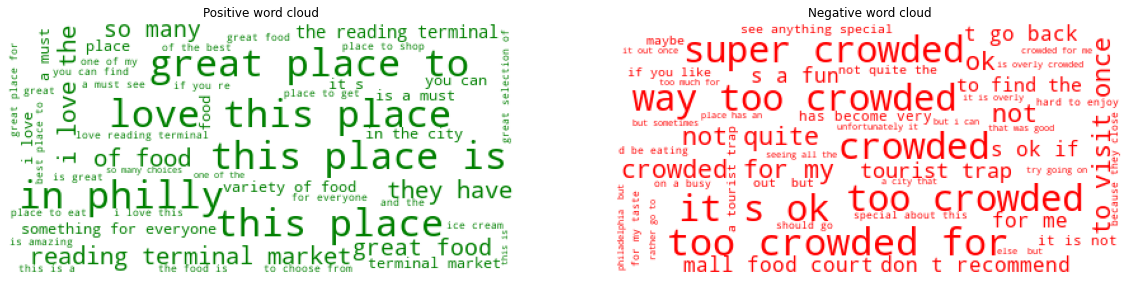

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# extracting the 50 positive and negative ngrams
negative_ngram = svm_coeffs_df_ngram.sort_values('weight')['ngram'].values[:50]
positive_ngram = svm_coeffs_df_ngram.sort_values('weight', ascending=False)['ngram'].values[:50]
positive_text = Counter(positive_ngram)
negative_text = Counter(negative_ngram)

# creating the word clouds for the negative and positive ngrams
wordcloud1 = WordCloud(background_color="white", color_func=lambda *args, **kwargs: "green", max_font_size=30, collocations=True).generate_from_frequencies(positive_text)
wordcloud2 = WordCloud(background_color="white", color_func=lambda *args, **kwargs: "red", max_font_size=30, collocations=True).generate_from_frequencies(negative_text)

# Generating the plot for word clouds created
plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1).set_title("Positive word cloud")
plt.plot()
plt.imshow(wordcloud1)
plt.axis("off")
plt.subplot(1, 2, 2).set_title("Negative word cloud")
plt.plot()
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()